# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model
from fastscape.processes import MultipleFlowRouter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import paraspec.taxon_lineage as txl

from paraspec.fastscape_ext import IR12Speciation, DD03Speciation, CompoundEnvironment, ElevationEnvField1, ElevationEnvField2 

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
    'life': IR12Speciation,
    'flow': MultipleFlowRouter
})

model

<xsimlab.Model (20 processes, 24 inputs)>
grid
    shape               [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length              [in] ('shape_yx',) total grid length in (y, x)
boundary
    status              [in] () or ('border',) node status at borders
fs_context
uplift
    rate                [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                [in] random seed
surf2erode
diffusion
    diffusivity         [in] () or ('y', 'x') diffusivity (transpor...
flow
    slope_exp           [in] () or ('y', 'x') MFD partioner slope e...
drainage
spl
    k_coef              [in] () or ('y', 'x') bedrock channel incis...
    area_exp            [in] drainage area exponent
    slope_exp           [in] slope exponent
init_erosion
erosion
vmotion
topography
terrain
elevation1
elevation2
life_env
life
    init_abundance      [in] initial number of individuals
    init_min_trait      [in] ('trait',) initial min trait value
    init_max_trait      [in] ('tra

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], #[201, 201],
        'grid__length': [1e5, 2e5], #[2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_abundance': 100,
            'init_max_trait': [0.5, 0.5],#[0.5],#
            'init_min_trait': [0.5, 0.5],#[0.5],#
            'slope_trait_env': [0.95, -0.95],#[0.95],#
            'min_env': [0, 0],#[0],#
            'max_env': [400, 400],#[400],#
            'nb_radius': 2e4,#2e3
            'car_cap': 30, #25
            'sigma_mov': 1000.,
            'mut_prob': 0.05,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.3, 
            'random_seed': 1234,
            'rescale_rates':False,
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out',
        'life__n_offspring': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

In [5]:
out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 101, y: 101, x: 201, shape_yx: 2, ind: 451, trait: 2, field: 2, time: 101)
Coordinates:
  * border                  (border) object 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * x                       (x) float64 0.0 1e+03 2e+03 ... 1.99e+05 2e+05
  * y                       (y) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx, ind, trait, field
Data variables: (12/34)
    boundary__status        (border) <U11 'looped' 'looped' ... 'fixed_value'
    diffusion__diffusivity  float64 0.001
    drainage__area          (out, y, x) float64 2.175e+06 2.44e+06 ... 4.865e+06
    flow__slope_exp         float64 1.0
    grid__length            (shape_yx) float64 1e+05 2e+05
    grid__shape             (shape_yx) int64 101 201
    ...                      ...
    life__y                 (out, ind) float64 5.724e+04 4.91e+04 ... nan nan
    spl__area_exp           float64 0.4
    spl__k_coef             float64 0.0001
    spl__slope_exp          int64 1
    topography__elevation   (out, y, x) float64 0.7073 0.7427 ... 0.231 0.3759
    uplift__rate            float64 0.001

In [6]:
individuals_data = {}
for i in range(out_ds.life__trait.shape[2]):
    individuals_data['life__trait_'+str(i)] = out_ds.life__trait[:,:,i]
out_ds=out_ds.assign(individuals_data)

In [7]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
)

df

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
1.0,0.0,1,0.0,1.0,1.0,1.0,1.0,414.215347,49101.865736,0.500000,0.500000
3.0,0.0,3,0.0,3.0,1.0,3.0,1.0,161361.778440,46378.641078,0.500000,0.500000
8.0,0.0,8,0.0,8.0,1.0,8.0,1.0,146186.247303,64638.600514,0.500000,0.500000
9.0,0.0,9,0.0,9.0,1.0,9.0,1.0,136494.208833,42140.410817,0.500000,0.500000
10.0,0.0,10,0.0,10.0,1.0,10.0,1.0,152518.261768,22633.227006,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
36201.0,990000.0,439,1457.0,36201.0,1.0,35757.0,1488.0,180765.012769,87298.680172,0.344573,0.689685
36202.0,990000.0,440,1459.0,36202.0,1.0,35758.0,1484.0,174289.442164,92637.822300,0.430342,0.694472
36203.0,990000.0,441,1457.0,36203.0,1.0,35759.0,1488.0,176771.660929,89643.345916,0.350313,0.700732


In [8]:
df.out.unique()

array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
        70000.,  80000.,  90000., 100000., 110000., 120000., 130000.,
       140000., 150000., 160000., 170000., 180000., 190000., 200000.,
       210000., 220000., 230000., 240000., 250000., 260000., 270000.,
       280000., 290000., 300000., 310000., 320000., 330000., 340000.,
       350000., 360000., 370000., 380000., 390000., 400000., 410000.,
       420000., 430000., 440000., 450000., 460000., 470000., 480000.,
       490000., 500000., 510000., 520000., 530000., 540000., 550000.,
       560000., 570000., 580000., 590000., 600000., 610000., 620000.,
       630000., 640000., 650000., 660000., 670000., 680000., 690000.,
       700000., 710000., 720000., 730000., 740000., 750000., 760000.,
       770000., 780000., 790000., 800000., 810000., 820000., 830000.,
       840000., 850000., 860000., 870000., 880000., 890000., 900000.,
       910000., 920000., 930000., 940000., 950000., 960000., 970000.,
       980000., 9900

In [9]:
df.loc[df.out==df.out.unique()[0]]

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
1.0,0.0,1,0.0,1.0,1.0,1.0,1.0,414.215347,49101.865736,0.5,0.5
3.0,0.0,3,0.0,3.0,1.0,3.0,1.0,161361.778440,46378.641078,0.5,0.5
8.0,0.0,8,0.0,8.0,1.0,8.0,1.0,146186.247303,64638.600514,0.5,0.5
9.0,0.0,9,0.0,9.0,1.0,9.0,1.0,136494.208833,42140.410817,0.5,0.5
10.0,0.0,10,0.0,10.0,1.0,10.0,1.0,152518.261768,22633.227006,0.5,0.5
16.0,0.0,16,0.0,16.0,1.0,16.0,1.0,144692.816094,3867.473627,0.5,0.5
18.0,0.0,18,0.0,18.0,1.0,18.0,1.0,196073.915496,16813.430172,0.5,0.5
20.0,0.0,20,0.0,20.0,1.0,20.0,1.0,9383.683718,440.917488,0.5,0.5
24.0,0.0,24,0.0,24.0,1.0,24.0,1.0,9.225718,91889.342391,0.5,0.5


## Plot population

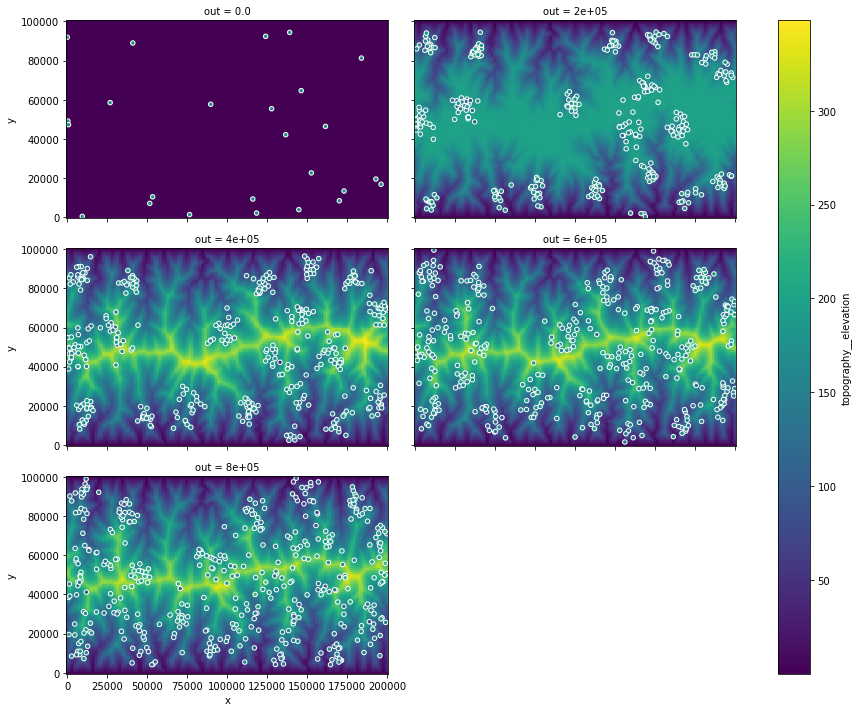

In [10]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_0, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

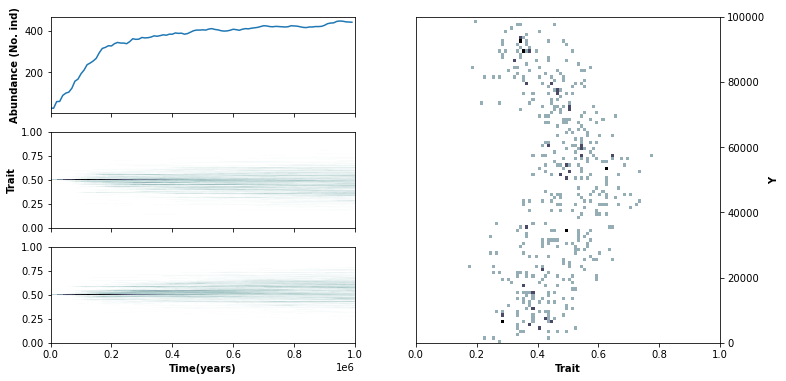

In [11]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, -1]:
    ax.remove()
axbig = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df['out'], y=df['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df['trait_0'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')

axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs2[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait', weight='bold')
axs2[2,0].set_xlabel('Time(years)', weight='bold')

In [12]:
taxon_lineage1 = txl.dtf_taxon(df.rename(columns={'out':'time'}))
taxon_lineage1

,time,id,parent,trait_0,trait_1,abundance,node_type,branch_length
0,0.0,1.0,0.0,0.500000,0.500000,25,root,0.001
1,10000.0,2.0,1.0,0.499742,0.499911,25,node,10000.001
2,20000.0,3.0,2.0,0.501491,0.499956,57,node,10000.001
3,30000.0,4.0,3.0,0.501332,0.499789,58,node,10000.001
4,40000.0,5.0,4.0,0.500544,0.501433,87,node,10000.001
...,...,...,...,...,...,...,...,...
1506,990000.0,1508.0,1465.0,0.585822,0.492185,20,leaf,0.001
1507,990000.0,1509.0,1466.0,0.371714,0.584175,10,leaf,0.001
1508,990000.0,1510.0,1467.0,0.436351,0.381174,10,leaf,0.001
1509,990000.0,1511.0,1468.0,0.492263,0.454258,12,leaf,0.001


In [13]:
tree1 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage1)

In [14]:
tree1.print_plot()

                                                            /+++++++++++ 1505.0
       /+++++++++++++++++++++++++++++++++++++++++++++++++++++                  
       |                                                    \+++++++++++ 1506.0
       |                                                                       
       |        /+++++++++++++++++++++++++++++++++++++++++++++++++++++++ 1500.0
       |+++++++++                                                              
       |        |                     /+++++++++++++++++++++++++++++++++ 1507.0
       |        \++++++++++++++++++++++                                        
       |                              |                    /++++++++++++ 1502.0
       |                              \+++++++++++++++++++++                   
       |                                                   |       /++++ 1488.0
++++++++                                                   \++++++++           
       |                                

## Speciation with competition in an evolving landscape

In [15]:
model2 = basic_model.update_processes({
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
    'life': DD03Speciation,
    'flow': MultipleFlowRouter
})
model2

<xsimlab.Model (20 processes, 27 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                 [in] random seed
surf2erode
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
flow
    slope_exp            [in] () or ('y', 'x') MFD partioner slope ...
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
init_erosion
erosion
vmotion
topography
terrain
elevation1
elevation2
life_env
life
    init_abundance       [in] initial number of individuals
    init_min_trait       [in] ('trait',) initial min trait value
    init_max_trait       [i

In [16]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [1e5, 2e5],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_abundance': 100,
            'init_min_trait': [0.5, 0.5],
            'init_max_trait': [0.5, 0.5],
            'slope_trait_env': [0.95, -0.95],
            'min_env': [0, 0],
            'max_env': [400, 400],
            'birth_rate': 1.,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'sigma_env_trait': 0.3,
            'mut_prob': 0.05,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_comp_trait': 0.9,
            'sigma_comp_dist': 0.1,
            'random_seed': 1234,
            'rescale_rates': False
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out',
        'life__n_offspring': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [17]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [18]:
individuals_data2 = {}
for i in range(out_ds2.life__trait.shape[2]):
    individuals_data2['life__trait_'+str(i)] = out_ds2.life__trait[:,:,i]
out_ds2=out_ds2.assign(individuals_data2)

In [19]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
)


df2

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
1.0,0.0,1,0.0,1.0,1.0,1.0,1.0,414.215347,49101.865736,0.500000,0.500000
2.0,0.0,2,0.0,2.0,1.0,2.0,1.0,161871.264117,71968.886030,0.500000,0.500000
3.0,0.0,3,0.0,3.0,1.0,3.0,1.0,161361.778440,46378.641078,0.500000,0.500000
4.0,0.0,4,0.0,4.0,2.0,4.0,1.0,10906.533328,85111.346187,0.500000,0.500000
5.0,0.0,5,0.0,5.0,1.0,5.0,1.0,19787.256556,78833.267136,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
6112.0,990000.0,567,793.0,6112.0,1.0,5993.0,798.0,7987.415473,55831.526564,0.497756,0.430264
6113.0,990000.0,568,793.0,6113.0,1.0,5999.0,798.0,148794.864510,85663.485512,0.500000,0.500000
6115.0,990000.0,570,782.0,6115.0,1.0,6008.0,807.0,4739.442213,6377.490608,0.472893,0.480861


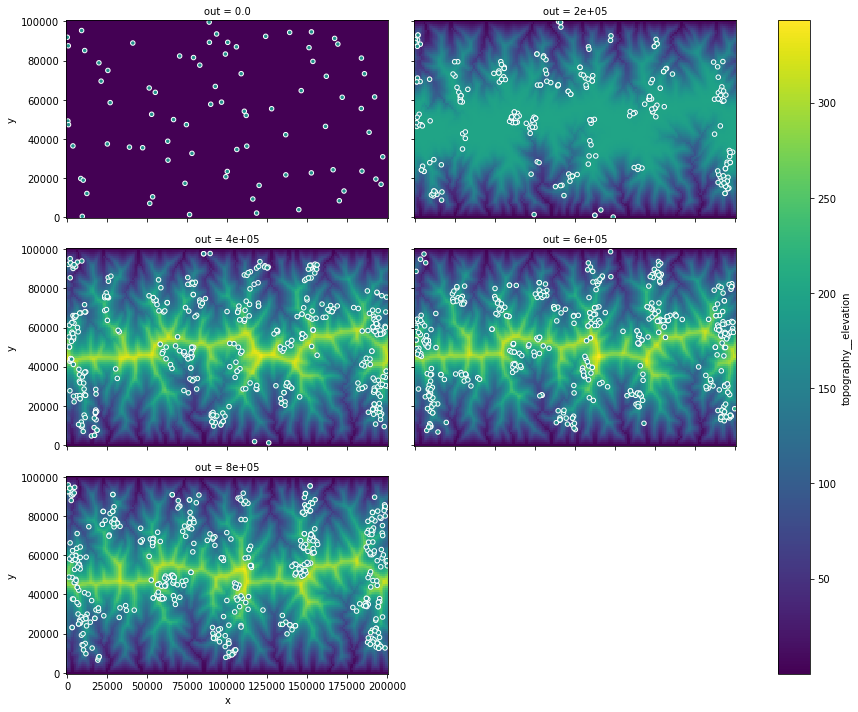

In [20]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds2.topography__elevation.max()


fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_0, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

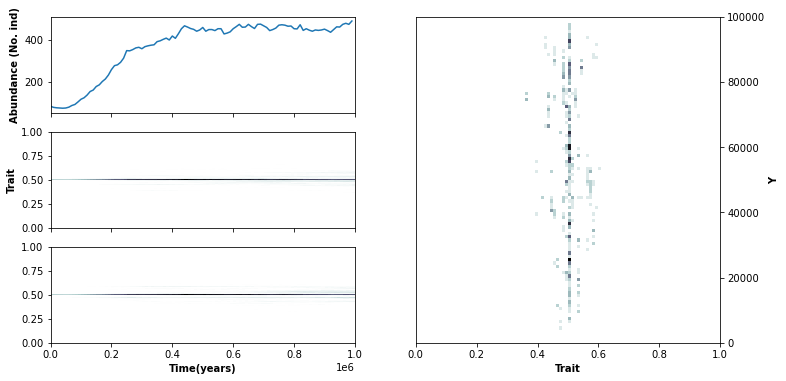

In [21]:
fig5, axs5 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, -1]:
    ax.remove()
axbig = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df2['trait_0'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs5[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait', weight='bold')
axs5[2,0].set_xlabel('Time(years)', weight='bold')

In [22]:
taxon_lineage2 = txl.dtf_taxon(df2.rename(columns={'out':'time'}))
taxon_lineage2

,time,id,parent,trait_0,trait_1,abundance,node_type,branch_length
0,0.0,1.0,0.0,0.500000,0.500000,81,root,0.001
1,10000.0,2.0,1.0,0.500000,0.500000,76,node,10000.001
2,20000.0,3.0,2.0,0.500000,0.500000,74,node,10000.001
3,30000.0,4.0,3.0,0.500000,0.500000,73,node,10000.001
4,40000.0,5.0,4.0,0.500220,0.499712,72,node,10000.001
...,...,...,...,...,...,...,...,...
804,990000.0,806.0,781.0,0.495525,0.498766,37,leaf,0.001
805,990000.0,807.0,782.0,0.503234,0.499769,27,leaf,0.001
806,990000.0,808.0,783.0,0.498966,0.500541,48,leaf,0.001
807,990000.0,809.0,785.0,0.492688,0.512250,9,leaf,0.001


In [23]:
tree2 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage2)

In [24]:
tree2.print_plot()

                                               ++++++++++++++++++++++++++ 810.0
                            /+++++++++++++++++++                               
                            |                  |/++++++++++++++++++++++++ 799.0
                            |                  ++                              
                            |                   |    ++++++++++++++++++++ 809.0
                            |                   \+++++                         
                            |                        |    /++++++++++++++ 804.0
                            +                        ++++++                    
                            |                             |           +++ 797.0
                            |                             \++++++++++++        
                            |                                         |++ 801.0
                          /++                                         +        
                          | |           